 # The Battle of Neighborhood – Capstone Project
 # Indian Restaurant analysis in Toronto

### Introduction

Toronto is the largest city of Canada with the Greater Toronto population of over 6 million. It is ethnically very diverse city with various cultures with which come numerous cuisines including Chinese, Indian, Italian etc . Canada, in particular Toronto has a significant Indian population. The project is to analysis the neighborhoods of Toronto to find best places with Indian restaurants and potentially help find area where there are business opportunities to open an Indian restaurant.  

Part of the project we will analyze and visualize major parts of Toronto with Indian restaurants. 

We will try to get answers to following question 

- Best places in Toronto to find good Indian restaurant
- Areas having potential market for Indian restaurant 
- Neighborhood to stay with good Indian restaurant



### Data
As we need to explore neighborhoods in the city of Toronto, the Toronto neighborhoods data is key for this project. Unfortunately, the data is for the Toronto neighborhood data is not widely available on the Internet in the structured format, hence we need to scrap it through an existing Wikipedia page exists that has all the information we need to explore and analyze the neighborhoods in Toronto.


### Steps 
- Web scrape Toronto neighborhood data with postal code from https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M
- We will find the Indian restaurant in each of these neigborhood using Foursuqre API. 
- With the Venu ID we can find the ratings of each of the Indian Restaurant identified.
- We rollup the data at neighborhood / Borough level with total Number of restaurant and also average rating
- We visualize the data using bar chart and also raking of the neighborhood on the Toronto map 

Improt the necessary libraries for this project 

In [158]:
import pandas as pd
import numpy  as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
from bs4 import BeautifulSoup
import geocoder
import os
import folium  
from geopy.geocoders import Nominatim  
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import requests
import lxml.html as lh
import pandas as pd
print('Libraries imported.')

Libraries imported.


Function to intract with FourSquare API and get top 100 venues within a radius of 1000 metres for a given  latitude and longitude. The function returns the venue id , venue name and category.

In [159]:
def get_venues(lat,lng):
    #set variables
    CLIENT_ID     = 'BTSLK3PHLSXUMNH4JETQXWNEZ42OUCCSSMVAKL3JDDYV1EQI' # your Foursquare ID
    CLIENT_SECRET = 'OEVWBX31FTKFFZZZPIGUC4IO13UWZRVJN4MNBCU3BQU3JPA2' # your Foursquare Secret
    VERSION       = '20190605'                                         # Foursquare API version
    radius        =1000
    LIMIT         =100
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the venus 
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    # get data for the venus 
    
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df          = pd.DataFrame(venue_details,columns=column_names)
    
    return df

The function is to get the Venu details 

In [160]:
def get_venue_details(venue_id):
        
    CLIENT_ID     = 'BTSLK3PHLSXUMNH4JETQXWNEZ42OUCCSSMVAKL3JDDYV1EQI' # your Foursquare ID
    CLIENT_SECRET = 'OEVWBX31FTKFFZZZPIGUC4IO13UWZRVJN4MNBCU3BQU3JPA2' # your Foursquare Secret
    VERSION       = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url           = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
                     venue_id,
                     CLIENT_ID, 
                     CLIENT_SECRET, 
                     VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    
    return df



### Web scraping for Toronto neighborhood and build a clean dataframe

Read and laod the data ( Postal code , Borough and Neighborhood) from "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" and store in a Data frame 

In [161]:
#Get table from the Wikipedia page and store it in tr_elements

url  = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

page = requests.get(url)
doc  = lh.fromstring(page.content)
tr_elements = doc.xpath('//tr')
#Turn the table in tr_elements into a dataframe
table_c = [["" for x in range(3)] for y in range(len(tr_elements))] 
for i in range(0, len(tr_elements)):
    if len(tr_elements[i]) == 3:
        for index, t in enumerate(tr_elements[i]):
            data = t.text_content()
            if index == 2:
                data = data.replace("\n", "")
            table_c[i][index] = data
        
del table_c[-5:]

df = pd.DataFrame(table_c)

header = df.iloc[0]
df = df[1:]
df.columns = header

#Delete rows where column 'Borough' is 'Not assigned'
df = df[df.Borough != 'Not assigned']

#Replace the 'Not assigned' in column 'Neighbourhood' with the borough name
df['Neighbourhood'].replace('Not assigned', df['Borough'], inplace = True)

#Merge all the neighbourhoods with the same postcode and borough name
df = df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(', '.join).reset_index()

df.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


For each of the Postcode identify Coordinates 

In [162]:
url_geo = 'http://cocl.us/Geospatial_data'
df_geo = pd.read_csv(url_geo)
df_geo.rename(columns = {'Postal Code': 'Postcode'}, inplace = True) #Change column name so it's the same with the first dataframe
df_geo.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In the first data frame add the Latitude and longitude 

In [163]:
#Build a new datafrome with both neighbourhood and coordinate information
df_merge = pd.merge(df, df_geo, on = 'Postcode')
df_merge.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [164]:
df           = df_merge[['Borough','Neighbourhood', 'Latitude','Longitude']]
Toranto_data =df.sort_values(by=['Borough','Neighbourhood'])
Toranto_data.head()

,Borough,Neighbourhood,Latitude,Longitude
47,Central Toronto,Davisville,43.704324,-79.388790
45,Central Toronto,Davisville North,43.712751,-79.390197
49,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049
64,Central Toronto,"Forest Hill North, Forest Hill West",43.696948,-79.411307
44,Central Toronto,Lawrence Park,43.728020,-79.388790


In [165]:
Toranto_data.shape

(103, 4)

Let us visualize how many neighborhoods are there in each Borough 

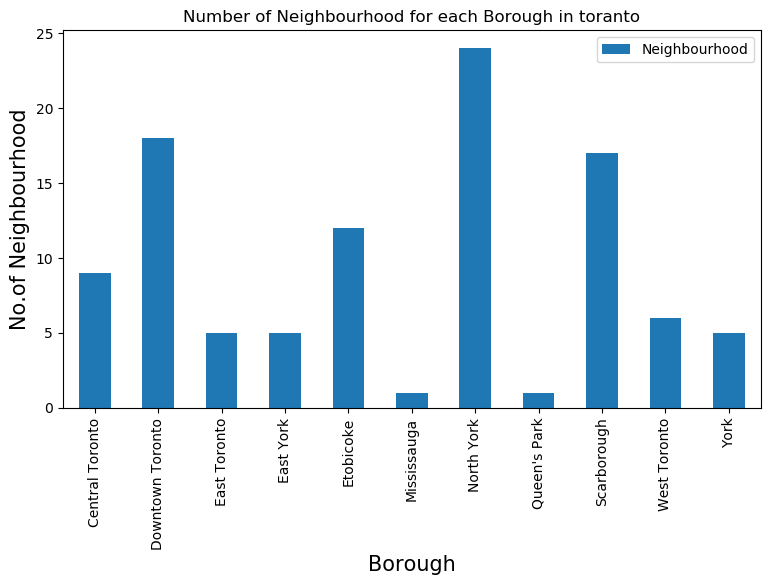

In [166]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Neighbourhood for each Borough in toranto')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighbourhood', fontsize=15)
#giving a bar plot
Toranto_data.groupby('Borough')['Neighbourhood'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Norh York has the heighest number of neighborhoods. 

We will use the function which used Forquare API to identify venus for all the list of cocordinated, we will filter only the venus with category of Indian Restaurant


In [167]:
# prepare neighbourhood list that contains indian resturants
column_names=['Borough', 'Neighbourhood', 'ID','Name']
indian_rest_Toronto=pd.DataFrame(columns=column_names)
count=1
for row in Toranto_data.values.tolist():
    Borough, Neighbourhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(Toranto_data),')','Indian Restaurant '+Neighbourhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_Toronto = indian_rest_Toronto.append({'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 103 ) Indian Restaurant Davisville, Central Toronto:2
( 2 / 103 ) Indian Restaurant Davisville North, Central Toronto:0
( 3 / 103 ) Indian Restaurant Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West, Central Toronto:0
( 4 / 103 ) Indian Restaurant Forest Hill North, Forest Hill West, Central Toronto:0
( 5 / 103 ) Indian Restaurant Lawrence Park, Central Toronto:0
( 6 / 103 ) Indian Restaurant Moore Park, Summerhill East, Central Toronto:0
( 7 / 103 ) Indian Restaurant North Toronto West, Central Toronto:0
( 8 / 103 ) Indian Restaurant Roselawn, Central Toronto:0
( 9 / 103 ) Indian Restaurant The Annex, North Midtown, Yorkville, Central Toronto:2
( 10 / 103 ) Indian Restaurant Adelaide, King, Richmond, Downtown Toronto:0
( 11 / 103 ) Indian Restaurant Berczy Park, Downtown Toronto:0
( 12 / 103 ) Indian Restaurant CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara, Downtown Toronto:0
( 13 / 103 ) Indian Restau

In [168]:
indian_rest_Toronto.shape

(46, 4)

Here is the sample of the data frame containing all the Indian restaurant with corresponding Neighborhood and Borough details 

In [169]:
indian_rest_Toronto.head()

,Borough,Neighbourhood,ID,Name
0,Central Toronto,Davisville,5169d445e4b07de190b5c3d6,Marigold Indian Bistro
1,Central Toronto,Davisville,4b7ccc72f964a520e3a52fe3,Banjara Indian Cuisine
2,Central Toronto,"The Annex, North Midtown, Yorkville",4c62c59ce1621b8dd0332453,Roti Cuisine of India
3,Central Toronto,"The Annex, North Midtown, Yorkville",4ad4c060f964a5204af720e3,The Host
4,Downtown Toronto,"Cabbagetown, St. James Town",4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory


In [170]:
#indian_rest_Toronto.to_csv('indian_rest_toranto.csv', index=False)

#Toranto_data.to_csv('Toranto_data.csv', index=False)

We will visualize the number of indian restaurant in each of the Borough 

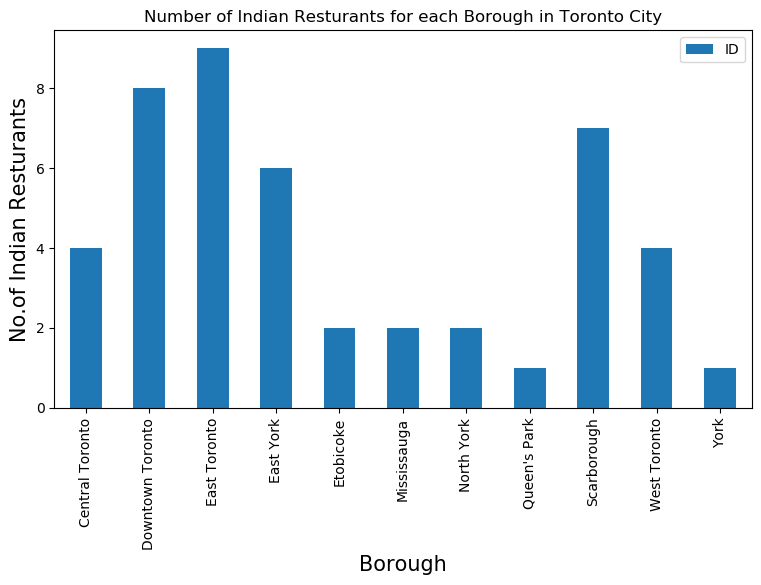

In [171]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Borough in Toronto City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_Toronto.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We will visualize the number of indian restaurant in each of the Neighborhood(Top 5 with most indian Restaurant)

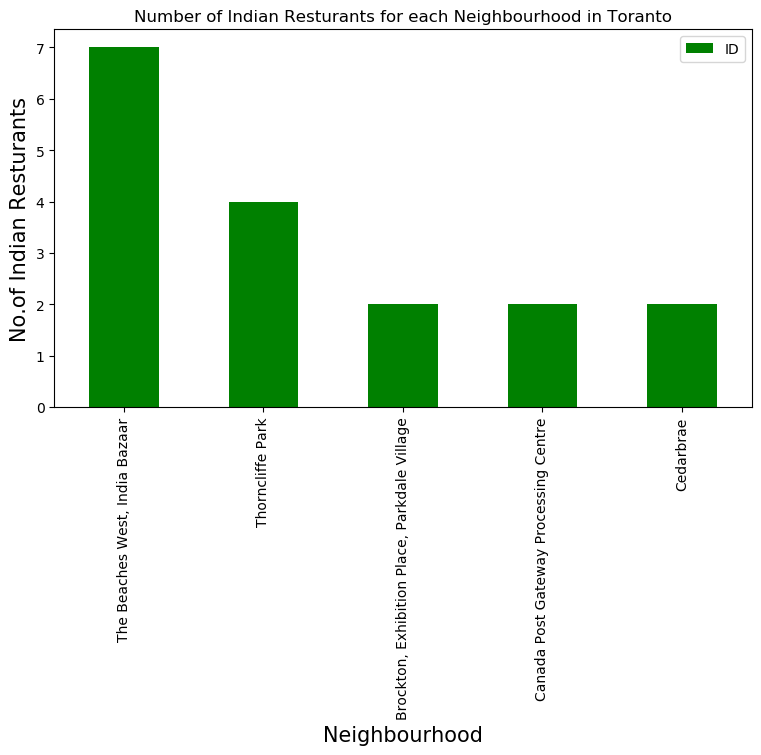

In [172]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighbourhood in Toranto')
#On x-axis
plt.xlabel('Neighbourhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_Toronto.groupby('Neighbourhood')['ID'].count().nlargest(5).plot(kind='bar',color='green')
#legend
plt.legend()
#displays the plot
plt.show()

In [173]:
indian_rest_Toronto[indian_rest_Toronto['Neighbourhood']=='The Beaches West, India Bazaar']

,Borough,Neighbourhood,ID,Name
13,East Toronto,"The Beaches West, India Bazaar",4ae0c7a8f964a520638221e3,Udupi Palace
14,East Toronto,"The Beaches West, India Bazaar",4afc9816f964a520312422e3,Motimahal
15,East Toronto,"The Beaches West, India Bazaar",4bac30a2f964a52018ea3ae3,Bombay Chowpatty
16,East Toronto,"The Beaches West, India Bazaar",4ad9052cf964a520301721e3,Regency Restaurant
17,East Toronto,"The Beaches West, India Bazaar",4bbcc0efa0a0c9b60ebd1a0f,Haandi 2000
18,East Toronto,"The Beaches West, India Bazaar",4d8d278a1d06b1f712942a3b,Gautama
19,East Toronto,"The Beaches West, India Bazaar",4edd30c09adfe5cbe2818dc4,Lahori Taste & Burger House


In [174]:
# prepare neighbourhood list that contains indian resturants
column_names=['Borough', 'Neighbourhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_Toronto=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_Toronto.values.tolist():
    Borough,Neighbourhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_Toronto),')','processed')
    indian_rest_stats_Toronto = indian_rest_stats_Toronto.append({'Borough': Borough,
                                                'Neighbourhood': Neighbourhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID                    Name  Likes  Rating  Tips
0  5169d445e4b07de190b5c3d6  Marigold Indian Bistro     11     7.9    11
( 1 / 46 ) processed
                         ID                    Name  Likes  Rating  Tips
0  4b7ccc72f964a520e3a52fe3  Banjara Indian Cuisine     24     6.7    19
( 2 / 46 ) processed
                         ID                   Name  Likes  Rating  Tips
0  4c62c59ce1621b8dd0332453  Roti Cuisine of India     39     8.6    18
( 3 / 46 ) processed
                         ID      Name  Likes  Rating  Tips
0  4ad4c060f964a5204af720e3  The Host     31     7.3    13
( 4 / 46 ) processed
                         ID                    Name  Likes  Rating  Tips
0  4c8c21fdf0ce236ab28e15ef  Butter Chicken Factory     19     8.5    10
( 5 / 46 ) processed
                         ID           Name  Likes  Rating  Tips
0  5afda69cfe0e2a002455224b  My Roti Place      9     8.2     3
( 6 / 46 ) processed
                         ID                   

In [175]:
indian_rest_stats_Toronto.head()

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips
0,Central Toronto,Davisville,5169d445e4b07de190b5c3d6,Marigold Indian Bistro,11,7.9,11
1,Central Toronto,Davisville,4b7ccc72f964a520e3a52fe3,Banjara Indian Cuisine,24,6.7,19
2,Central Toronto,"The Annex, North Midtown, Yorkville",4c62c59ce1621b8dd0332453,Roti Cuisine of India,39,8.6,18
3,Central Toronto,"The Annex, North Midtown, Yorkville",4ad4c060f964a5204af720e3,The Host,31,7.3,13
4,Downtown Toronto,"Cabbagetown, St. James Town",4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory,19,8.5,10


In [176]:
indian_rest_Toronto.head()

,Borough,Neighbourhood,ID,Name
0,Central Toronto,Davisville,5169d445e4b07de190b5c3d6,Marigold Indian Bistro
1,Central Toronto,Davisville,4b7ccc72f964a520e3a52fe3,Banjara Indian Cuisine
2,Central Toronto,"The Annex, North Midtown, Yorkville",4c62c59ce1621b8dd0332453,Roti Cuisine of India
3,Central Toronto,"The Annex, North Midtown, Yorkville",4ad4c060f964a5204af720e3,The Host
4,Downtown Toronto,"Cabbagetown, St. James Town",4c8c21fdf0ce236ab28e15ef,Butter Chicken Factory


In [177]:
#indian_rest_stats_Toronto.to_csv('indian_rest_stats_toranto.csv', index=False)

In [178]:
indian_rest_stats_Toronto['Likes']=indian_rest_stats_Toronto['Likes'].astype('float64')
indian_rest_stats_Toronto['Tips']=indian_rest_stats_Toronto['Tips'].astype('float64')

In [179]:
#indian_rest_stats_Toronto.info()

In [180]:
Toronto_neighbourhood_stats=indian_rest_stats_Toronto.groupby('Neighbourhood',as_index=False).mean()[['Neighbourhood','Rating']]
Toronto_neighbourhood_stats.columns=['Neighbourhood','Average Rating']

In [181]:
Toronto_neighbourhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighbourhood,Average Rating
3,"Cabbagetown, St. James Town",8.50
7,Christie,8.50
14,"High Park, The Junction South",8.30
19,Queen's Park,8.20
6,"Chinatown, Grange Park, Kensington Market",8.20
8,Church and Wellesley,8.20
2,"Brockton, Exhibition Place, Parkdale Village",8.05
21,"The Annex, North Midtown, Yorkville",7.95
17,"Maryvale, Wexford",7.80
12,"Harbourfront East, Toronto Islands, Union Station",7.60


In [182]:
Toronto_borough_stats=indian_rest_stats_Toronto.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
Toronto_borough_stats.columns=['Borough','Average Rating']

In [183]:
Toronto_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
7,Queen's Park,8.2000
1,Downtown Toronto,7.9625
9,West Toronto,7.8000
0,Central Toronto,7.6250
4,Etobicoke,6.8500


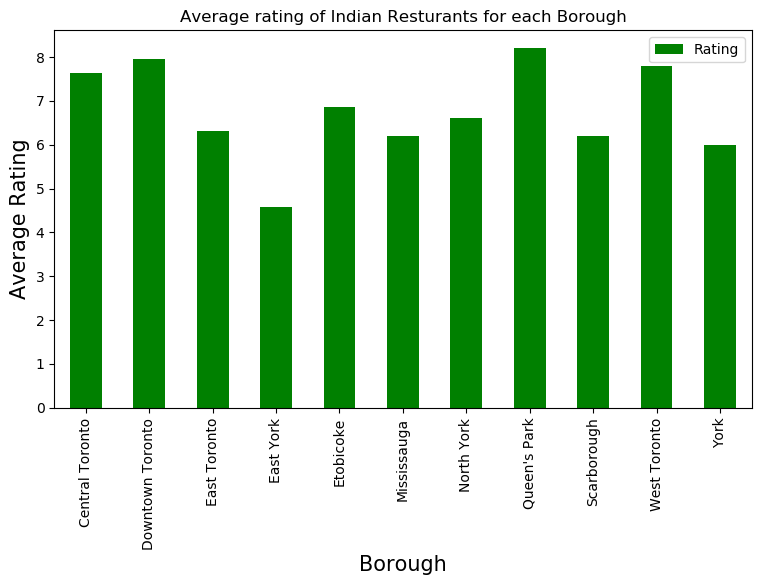

In [184]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_Toronto.groupby('Borough').mean()['Rating'].plot(kind='bar',color='green')
#legend
plt.legend()
#displays the plot
plt.show()

Let us Visualize Boroughs with their average Indian restaurant ratings

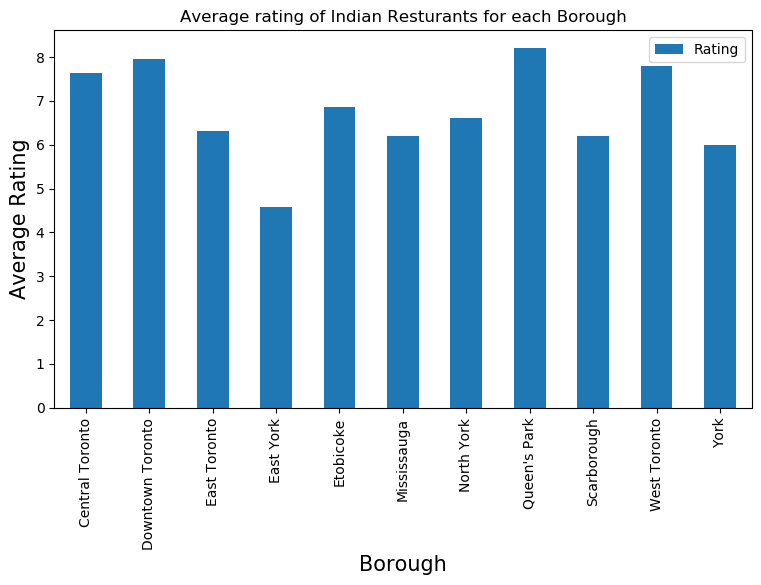

In [185]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Indian Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
indian_rest_stats_Toronto.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

No Let us list the top 5 neighborhood interms of number of indian restaurants .

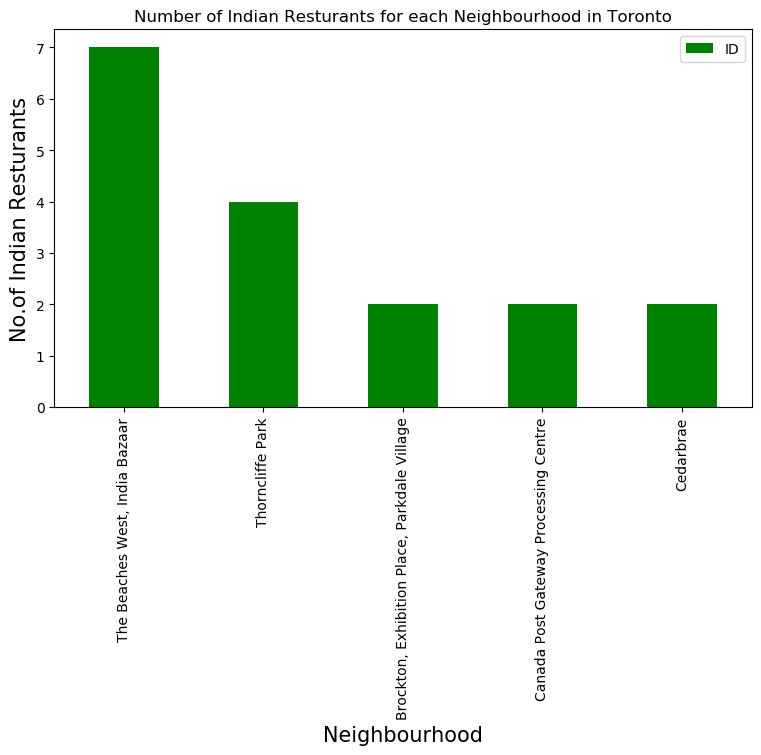

In [186]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Indian Resturants for each Neighbourhood in Toronto')
#On x-axis
plt.xlabel('Neighbourhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Indian Resturants', fontsize=15)
#giving a bar plot
indian_rest_Toronto.groupby('Neighbourhood')['ID'].count().nlargest(5).plot(kind='bar',color='green')
#legend
plt.legend()
#displays the plot
plt.show()

##### The Beaches West, India Bazaar has the most number of Indian Restaurant , let us list the restaurants in the order of top rating 

In [187]:
indian_rest_stats_Toronto[indian_rest_stats_Toronto['Neighbourhood']=='The Beaches West, India Bazaar']

,Borough,Neighbourhood,ID,Name,Likes,Rating,Tips
13,East Toronto,"The Beaches West, India Bazaar",4ae0c7a8f964a520638221e3,Udupi Palace,79.0,8.7,31.0
14,East Toronto,"The Beaches West, India Bazaar",4afc9816f964a520312422e3,Motimahal,25.0,7.8,13.0
15,East Toronto,"The Beaches West, India Bazaar",4bac30a2f964a52018ea3ae3,Bombay Chowpatty,7.0,7.5,5.0
16,East Toronto,"The Beaches West, India Bazaar",4ad9052cf964a520301721e3,Regency Restaurant,6.0,6.4,4.0
17,East Toronto,"The Beaches West, India Bazaar",4bbcc0efa0a0c9b60ebd1a0f,Haandi 2000,3.0,6.4,7.0
18,East Toronto,"The Beaches West, India Bazaar",4d8d278a1d06b1f712942a3b,Gautama,15.0,5.9,15.0
19,East Toronto,"The Beaches West, India Bazaar",0,0,0.0,0.0,0.0


###### let us list the top 3 Neighbor hood with higest average ratings 

In [198]:
Toronto_neighbourhood_stats1A=Toronto_neighbourhood_stats[Toronto_neighbourhood_stats['Average Rating']>=8.3]

In [199]:
Toronto_neighbourhood_stats1A

,Neighbourhood,Average Rating
3,"Cabbagetown, St. James Town",8.5
7,Christie,8.5
14,"High Park, The Junction South",8.3


### We will show the top 3 neighbourhood with highest Average rating in on the Map

In [200]:
#Toronto_neighbourhood_stats=pd.merge(Toronto_neighbourhood_stats,Toranto_data, on='Neighbourhood')

In [201]:
Toronto_neighbourhood_stats1=pd.merge(Toronto_neighbourhood_stats1A,Toranto_data, on='Neighbourhood')
Toronto_neighbourhood_stats1

,Neighbourhood,Average Rating,Borough,Latitude,Longitude
0,"Cabbagetown, St. James Town",8.5,Downtown Toronto,43.667967,-79.367675
1,Christie,8.5,Downtown Toronto,43.669542,-79.422564
2,"High Park, The Junction South",8.3,West Toronto,43.661608,-79.464763


In [202]:
# get geo location of address

def geo_location(address):
    geolocator = Nominatim(user_agent="Toronto_explorer")
    location   = geolocator.geocode(address)
    latitude   = location.latitude
    longitude  = location.longitude
    return latitude,longitude


In [203]:
Toronto_map = folium.Map(location=geo_location('Toronto'), zoom_start=12)

In [204]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in Toronto_neighbourhood_stats1[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )



In [205]:
Toronto_neighbourhood_stats1['Label']=Toronto_neighbourhood_stats1['Neighbourhood']+', '+Toronto_neighbourhood_stats1['Borough']+'('+Toronto_neighbourhood_stats1['Average Rating'].map(str)+')'

In [206]:
Toronto_neighbourhood_stats1

,Neighbourhood,Average Rating,Borough,Latitude,Longitude,Label
0,"Cabbagetown, St. James Town",8.5,Downtown Toronto,43.667967,-79.367675,"Cabbagetown, St. James Town, Downtown Toronto(..."
1,Christie,8.5,Downtown Toronto,43.669542,-79.422564,"Christie, Downtown Toronto(8.5)"
2,"High Park, The Junction South",8.3,West Toronto,43.661608,-79.464763,"High Park, The Junction South, West Toronto(8.3)"


In [207]:
# add pop-up text to each marker on the map
for lat, lng, label in Toronto_neighbourhood_stats1[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(Toronto_map)        
# add incidents to map
Toronto_map.add_child(incidents)

In [220]:
Toronto_borough_stats1A=Toronto_borough_stats[Toronto_borough_stats['Average Rating']>=7.8]
            
Toronto_borough_stats1A

,Borough,Average Rating
1,Downtown Toronto,7.9625
7,Queen's Park,8.2000
9,West Toronto,7.8000


#### Lets Visualize Boroughs based on average Rating

In [209]:
Toronto_map = folium.Map(location=geo_location('Toronto'), zoom_start=12)
Toronto_geo = r'toronto_crs84.geojson'

Toronto_map.choropleth(
    geo_data=Toronto_geo,
    data=Toronto_borough_stats,
    columns=['Borough', 'Average Rating'],
    key_on='feature.properties.boro_name',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Average Rating'
)

# display map
# as this is huge map data , we will save it to a file
Toronto_map.save('borough_rating.html')
Toronto_map

In [211]:
Toronto_neighbourhood_stats2A = Toronto_neighbourhood_stats
Toronto_neighbourhood_stats2=pd.merge(Toronto_neighbourhood_stats2A,Toranto_data, on='Neighbourhood')
Toronto_neighbourhood_stats.shape

(29, 2)

In [212]:
Toronto_map = folium.Map(location=geo_location('Toronto'), zoom_start=12)
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 crimes and add each to the incidents feature group
for lat, lng, in Toronto_neighbourhood_stats2[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )



In [148]:
Toronto_neighbourhood_stats2['Label']=Toronto_neighbourhood_stats2['Neighbourhood']+', '+Toronto_neighbourhood_stats2['Borough']+'('+Toronto_neighbourhood_stats2['Average Rating'].map(str)+')'

In [213]:
# add pop-up text to each marker on the map
for lat, lng, label in Toronto_neighbourhood_stats1[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(Toronto_map)        
# add incidents to map
Toronto_map.add_child(incidents)